In [1]:
import matplotlib.pyplot as plt
import math
import pandas as pd

In [2]:
df = pd.read_csv("../data/processed/trades_2025-10-01_to_2025-10-07_1min.csv")

In [3]:
class LCG:
    def __init__(self, seed=1, a=1664525, c=1013904223, m=2**32):
        self.x = seed % m
        self.a = a
        self.c = c
        self.m = m

    def next(self):
        self.x = (self.a * self.x + self.c) % self.m
        return self.x
    
    def random(self):
        return self.next()

    def sample(self, n):
        output = []
        for _ in range(n):
            output.append(self.next())
        return output

In [ ]:
class Unif(LCG):
    def __init__(self, a=0, b=1, seed=1, m=2**32):
        super().__init__(seed=seed, m=m)  # forward full LCG params
        self.low = a
        self.high = b
        self.m = m

    def next(self):
        x = super().next() / self.m
        # print(x*self.m)
        return self.low + (self.high - self.low) * x
    
    def random(self):
        return self.next()

    def sample(self, n):
        output = []
        for _ in range(n):
            output.append(self.next())
        return output

In [ ]:
class Gamma(Unif):
    def __init__(self, k, theta=1, seed=1, m=2**32):
        super().__init__(seed=seed, m=m)
        if k <= 0 or theta <= 0:
            raise ValueError("k and theta must be > 0")
        self.k = int(k)
        self.theta = theta

    def next(self):
        total = 0
        for _ in range(self.k):
            u = super().next()
            total += -math.log(1 - u) * self.theta
        return total

    def sample(self, n):
        return [self.next() for _ in range(n)]

In [ ]:
class Poisson(Unif):
    def __init__(self, lmda, seed =1, m = 2**32):
        super().__init__(seed = seed, m=m)
        if lmda <=0:
            raise ValueError("lmbda must be > 0")
        self.lmda = lmda
    

In [9]:
class Gamma_Poisson:
    def __init__(self, alpha, beta, lag, df: pd.DataFrame):
        if alpha <= 0 or beta <= 0:
            raise ValueError("alpha and beta must be > 0")
        if lag <=0:
            raise ValueError("lag must be a Natural number")
            
        self.alpha = alpha
        self.beta = beta
        self.lag = (lag)
        self.df = df
        
        self.params = {"alpha":[alpha], "beta":[beta]}

    def generate_posterior(self):
        df = self.df
        df = df.sort_values(by="timestamp").reset_index(drop=True)
        array = df["trade_count"].tolist()
        
        for i in range(len(array)):
            # index i time is i + 1
            sum_counts = 0
            upd_time = 0
            for j in range(max(0, i - self.lag + 1), i+1):
                sum_counts += array[j]
                upd_time = upd_time + 1

            self.params["alpha"].append(sum_counts + self.alpha)
            self.params["beta"].append(self.beta + upd_time)
            

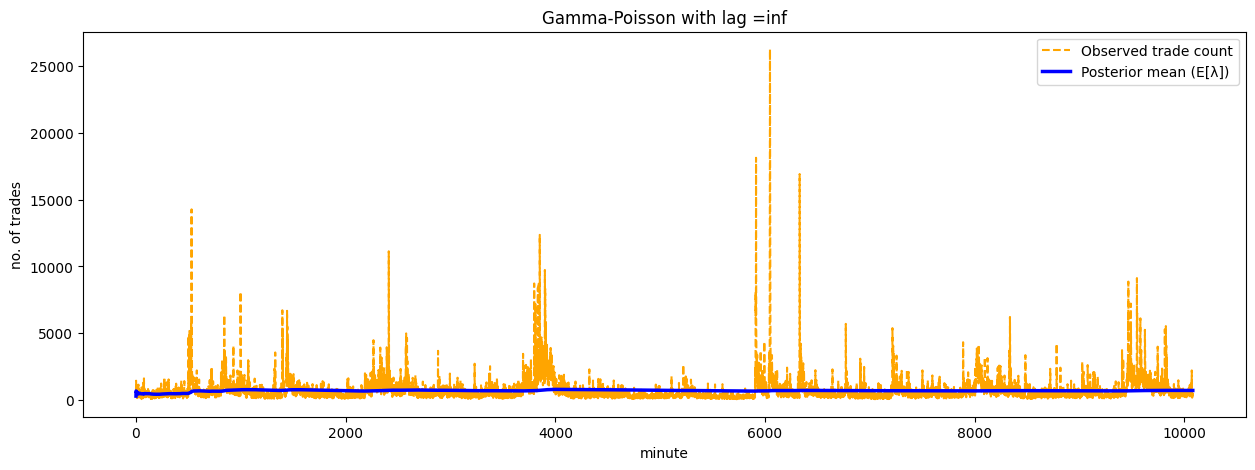

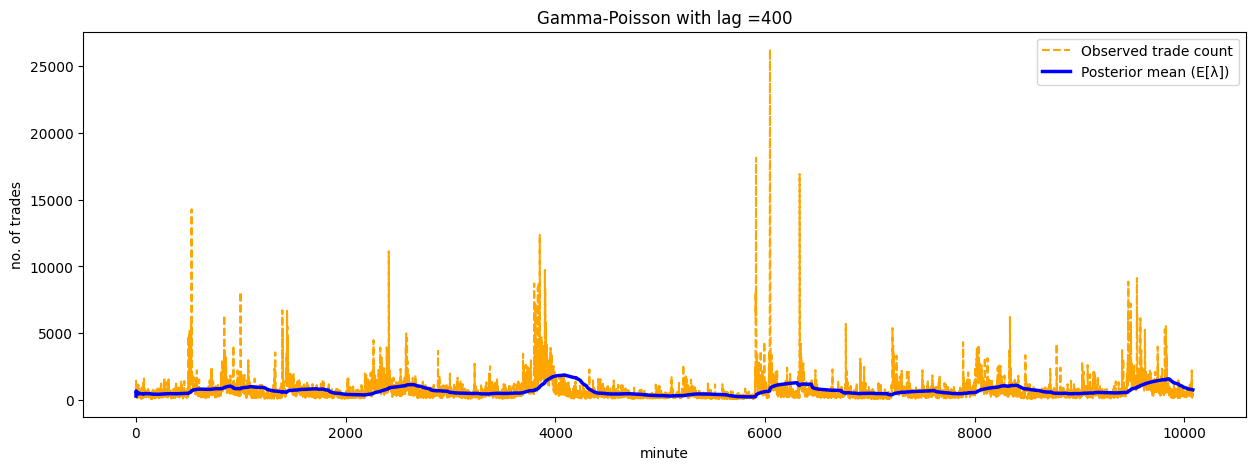

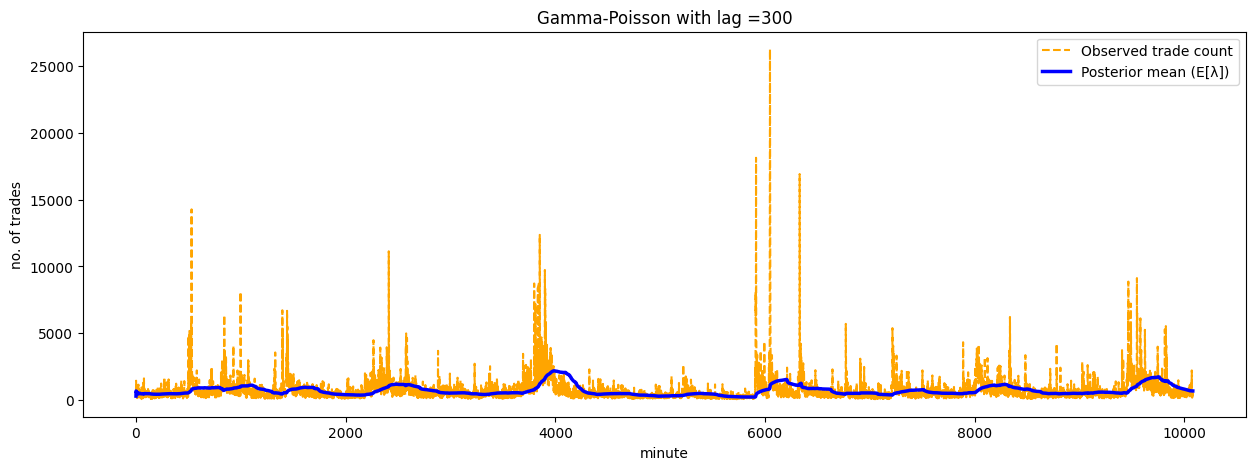

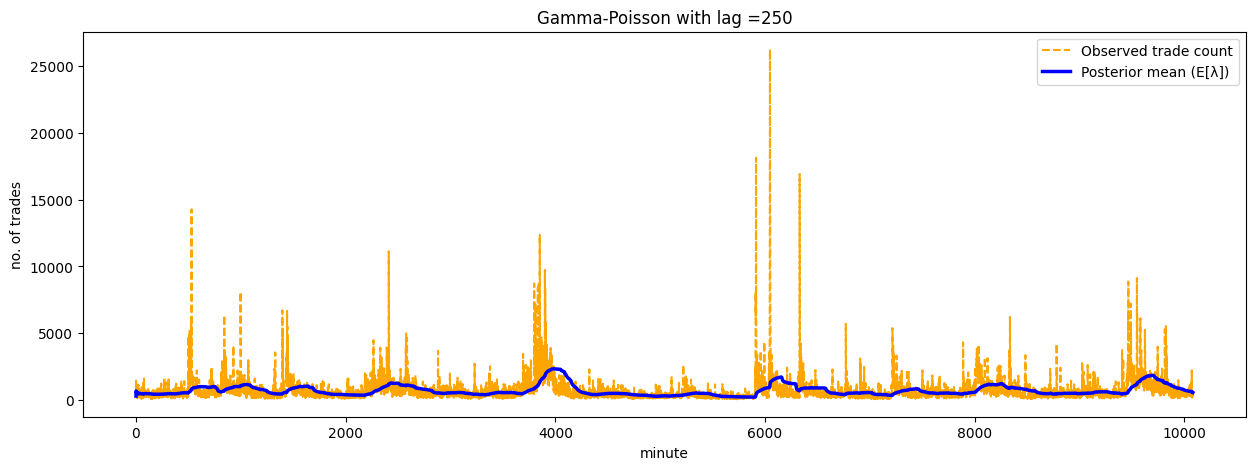

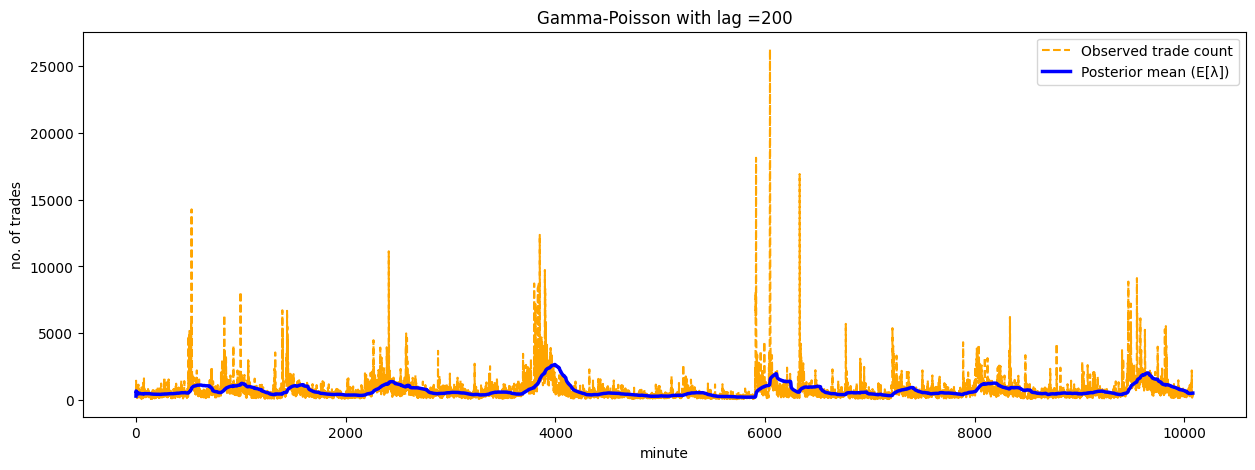

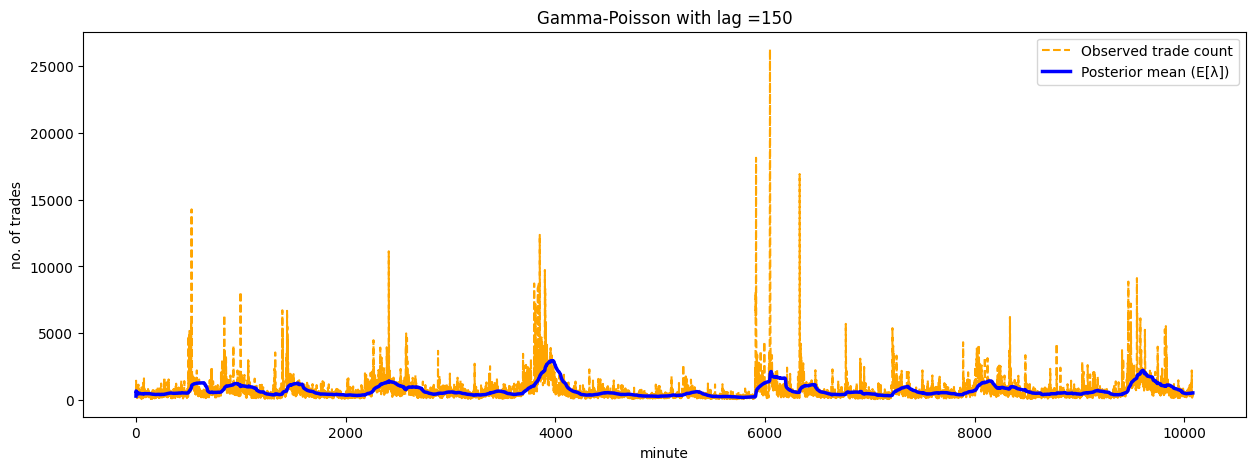

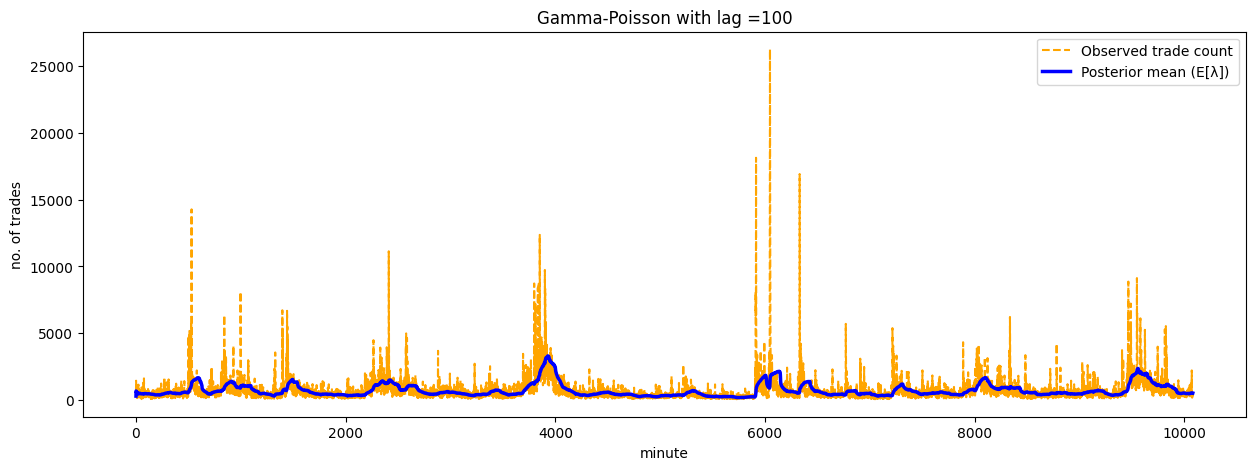

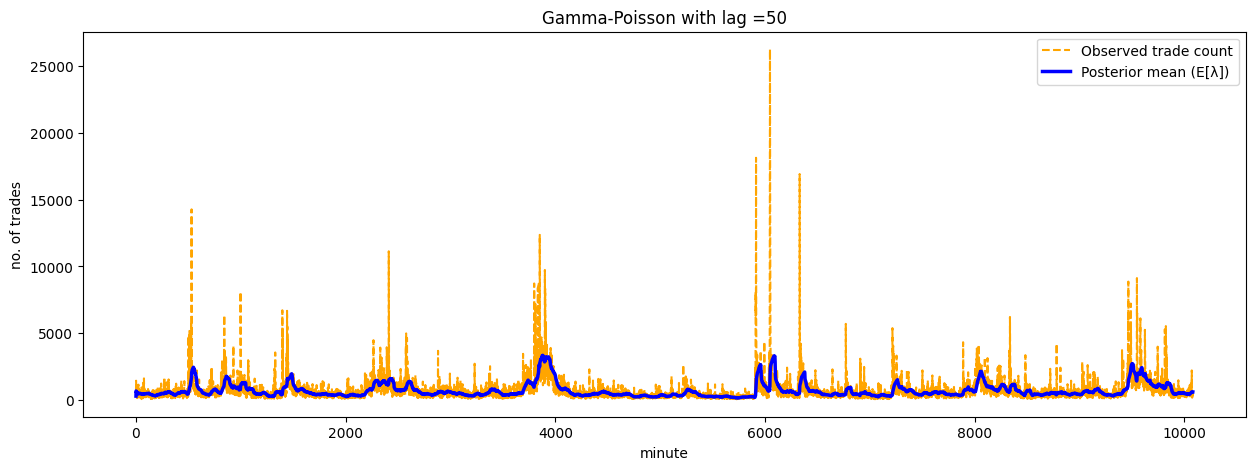

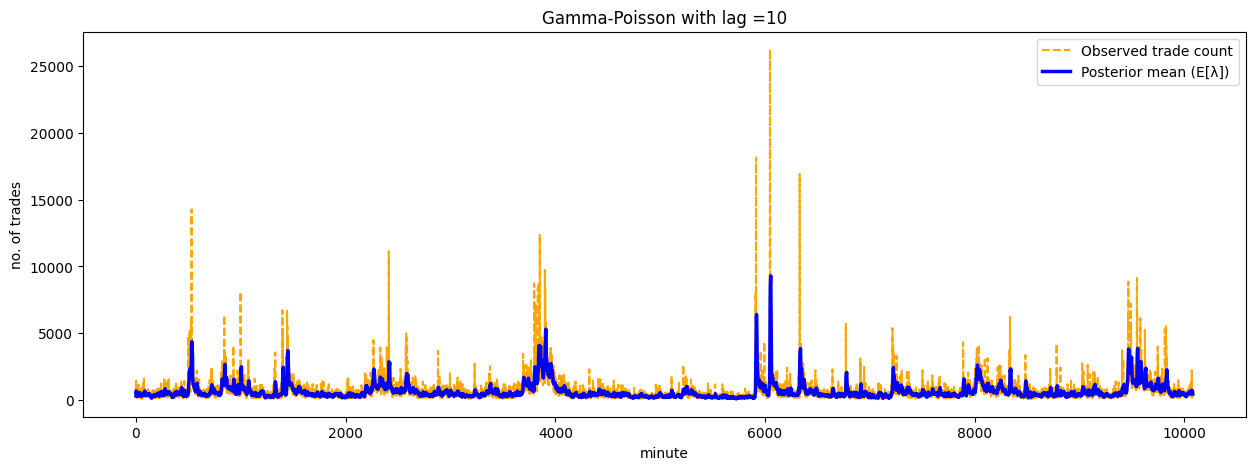

In [23]:
def expected_lambda(params, lag):
    plt.figure(figsize=(15,5))
    lmda = [alpha/beta for alpha, beta in zip(params["alpha"][1:],params["beta"][1:])]
    plt.xlabel("minute")
    plt.ylabel("no. of trades")

    plt.plot(df["trade_count"].values, color="orange", linestyle="--", label="Observed trade count")
    plt.plot(lmda, color="blue", linewidth=2.5, label="Posterior mean (E[λ])")
    
    plt.legend()
    plt.title(f"Gamma-Poisson with lag ={lag}")
    plt.show()

for lag in [float("inf"), 400, 300, 250, 200, 150, 100, 50, 10]:
    gp = Gamma_Poisson(1, 1, lag, df)
    gp.generate_posterior()
    expected_lambda(gp.params, lag)